#  📊 Baseline Models - Stock Price Prediction

### **Purpose:** Implement and evaluate baseline models to establish performance benchmarks

### **Dependencies:** `src/data.py`, `src/features.py`, `src/models.py`, `src/evaluate.py`

### **Baseline Models:**
- **Naive Last Value:** Uses the last known price as prediction
- **Random Walk with Drift:** Simple trend-following model
- **Random Forest:** Tree-based ensemble baseline
- **Linear Regression:** Classical linear model
 
### All models are evaluated using walk-forward validation to establish performance benchmarks for advanced models.

### **Results are saved to:** `experiments/` directory structure

## 🔧 Setup and Configuration

In [38]:

import sys
import os
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pickle
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

# Add project root to Python path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


## 📦 Import Existing Functions

In [39]:
# Import from existing modules - using functions from the index
from src.data import load_config, setup_logging, load_raw_data, clean_data, calculate_returns
from src.features import create_all_features, create_targets, validate_features, scale_features
from src.models import (NaiveLastValue, RandomWalkDrift, RandomForestPredictor, 
                       ModelRecord, evaluate_with_walk_forward)
from src.evaluate import (calculate_rmse, calculate_mae, calculate_mape, 
                         calculate_directional_accuracy, calculate_within_tolerance,
                         walk_forward_validation, compare_models, evaluate_regression_model,
                         statistical_significance_test, create_evaluation_report)
from src.utils import (ensure_dir_exists, save_results_to_json, timer_decorator,
                      generate_performance_report, plot_predictions_vs_actual,
                      plot_model_comparison, create_time_series_plot, get_project_path, safe_execute)

print("✅ All modules imported successfully")

✅ All modules imported successfully


## 🚀 Initialize Configuration and Logging

In [40]:
# Setup logging and configuration
logger = setup_logging()
config = load_config()

print("🚀 BASELINE MODELS - STOCK PRICE PREDICTION")
print("=" * 60)
print("Purpose: Establish performance benchmarks using baseline models")
print("Dependencies: src/data.py, src/features.py, src/models.py, src/evaluate.py")
print()

print("📋 Configuration Summary:")
print(f"   Target Horizons: {config['horizons']}")
print(f"   Stock Tickers: {config['data']['tickers']}")
print(f"   Available Models: {config['models']['types']}")
print(f"   Evaluation Metrics: {config['evaluation']['metrics']}")
print(f"   Date Range: {config['data']['date_range']['start_date']} to {config['data']['date_range']['end_date'] or 'current'}")


2025-09-26 09:25:15 - data - INFO - Logging configuration initialized
🚀 BASELINE MODELS - STOCK PRICE PREDICTION
Purpose: Establish performance benchmarks using baseline models
Dependencies: src/data.py, src/features.py, src/models.py, src/evaluate.py

📋 Configuration Summary:
   Target Horizons: [1, 7, 14, 28]
   Stock Tickers: ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN']
   Available Models: ['naive', 'random_walk', 'rf', 'lightgbm', 'xgboost']
   Evaluation Metrics: ['RMSE', 'MAE', 'MAPE', 'directional_accuracy', 'hit_rate']
   Date Range: 2020-01-01 to current


## 📊  1: Data Loading and Preparation

In [41]:
# Load processed data with features and prepare for baseline model training.

@timer_decorator
def load_and_prepare_data():
    """Load processed data and prepare features for baseline models."""
    
    tickers = config['data']['tickers']
    horizons = config['horizons']
    all_data = {}
    
    for ticker in tickers:
        print(f"📈 Loading data for {ticker}...")
        
        try:
            # Try to load pre-processed features first
            featured_data = load_raw_data(f"data/processed/{ticker}_features.csv")
            print(f"✅ Loaded pre-processed features for {ticker}")
        except FileNotFoundError:
            print(f"🔄 Processing raw data for {ticker}...")
            # Load and process raw data
            raw_data = load_raw_data(f"data/raw/{ticker}.csv")
            clean_data_df = clean_data(raw_data)
            
            # Create all features using existing function
            featured_data = create_all_features(clean_data_df)
            
            # Validate and scale features
            featured_data = validate_features(featured_data)
            featured_data, scaler = scale_features(featured_data, method=config['features']['scaling']['method'])
            
            # Save processed features
            ensure_dir_exists("data/processed")
            featured_data.to_csv(f"data/processed/{ticker}_features.csv")
        
        # Create target variables using existing function
        targets_data = create_targets(featured_data, horizons=horizons)
        all_data[ticker] = targets_data
        
        print(f"✅ {ticker}: {len(targets_data)} rows, {len(targets_data.columns)} features")
    
    return all_data

# Load all data
print("📊 STEP 1: Data Loading and Preparation")
print("-" * 50)
data_dict = load_and_prepare_data()

#  📈 Data Summary and Validation

print("\n📊 Data Summary:")
print("-" * 30)

for ticker, data in data_dict.items():
    print(f"\n{ticker}:")
    print(f"  📅 Date Range: {data.index[0].date()} to {data.index[-1].date()}")
    print(f"  📏 Shape: {data.shape}")
    print(f"  ❌ Missing Values: {data.isnull().sum().sum()}")
    
    # Show target columns
    target_cols = [col for col in data.columns if col.startswith('Target_')]
    print(f"  🎯 Target Columns: {target_cols}")


📊 STEP 1: Data Loading and Preparation
--------------------------------------------------
📈 Loading data for AAPL...
✅ Loaded pre-processed features for AAPL
2025-09-26 09:25:15 - data - INFO - Target variables created for horizons: [1, 7, 14, 28]
✅ AAPL: 1423 rows, 87 features
📈 Loading data for GOOGL...
✅ Loaded pre-processed features for GOOGL
2025-09-26 09:25:15 - data - INFO - Target variables created for horizons: [1, 7, 14, 28]
✅ GOOGL: 1423 rows, 87 features
📈 Loading data for MSFT...
✅ Loaded pre-processed features for MSFT
2025-09-26 09:25:15 - data - INFO - Target variables created for horizons: [1, 7, 14, 28]
✅ MSFT: 1423 rows, 87 features
📈 Loading data for TSLA...
✅ Loaded pre-processed features for TSLA
2025-09-26 09:25:15 - data - INFO - Target variables created for horizons: [1, 7, 14, 28]
✅ TSLA: 1423 rows, 87 features
📈 Loading data for AMZN...
✅ Loaded pre-processed features for AMZN
2025-09-26 09:25:15 - data - INFO - Target variables created for horizons: [1, 7, 1

## 🔧 2: Data Preparation Helper Functions

In [42]:
def prepare_data_for_horizon(data, horizon):
    """Prepare feature matrix X and target vector y for given horizon."""
    
    target_col = f'Target_{horizon}d'
    
    if target_col not in data.columns:
        raise ValueError(f"Target column {target_col} not found in data")
    
    # Feature columns (exclude targets and raw OHLCV)
    exclude_cols = [col for col in data.columns if col.startswith('Target_')]
    exclude_cols.extend(['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker'])
    
    feature_cols = [col for col in data.columns if col not in exclude_cols]
    
    # Prepare X and y
    X = data[feature_cols].copy()
    y = data[target_col].copy()
    
    # Remove rows with missing values
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    
    return X, y, feature_cols


print("✅ Data preparation functions defined")

✅ Data preparation functions defined


## # 🤖 3: Baseline Model Training and Evaluation

In [43]:
def train_baseline_models_for_horizon(ticker_data, ticker_name, horizon):
    """Train all baseline models for a single horizon."""
    
    print(f"\n🔧 Training models for {ticker_name} - {horizon}d horizon")
    print("-" * 50)
    
    try:
        X, y, feature_cols = prepare_data_for_horizon(ticker_data, horizon)
        print(f"📊 Features: {len(feature_cols)}, Samples: {len(X)}")
        
        if len(X) < 50:
            print(f"⚠️ Insufficient data after cleaning: {len(X)} samples")
            return None, None, None
            
    except ValueError as e:
        print(f"⚠️ Error preparing data for {horizon}d horizon: {e}")
        return None, None, None
    
    # Initialize baseline models using existing classes
    models = {
        'NaiveLastValue': NaiveLastValue(),
        'RandomWalkDrift': RandomWalkDrift(),
        'RandomForest': RandomForestPredictor(),
        'LinearRegression': LinearRegression()
    }
    
    model_results = []
    model_objects = {}
    predictions_dict = {}
    
    # Split data for training
    test_size = config['evaluation'].get('test_size', 0.2)
    train_size = int(len(X) * (1 - test_size))
    
    if train_size < 30:
        print(f"⚠️ Insufficient training data: {train_size} samples")
        return None, None, None
    
    X_train, X_test = X.iloc[:train_size].copy(), X.iloc[train_size:].copy()
    y_train, y_test = y.iloc[:train_size].copy(), y.iloc[train_size:].copy()
    
    print(f"📊 Train size: {len(X_train)}, Test size: {len(X_test)}")
    
    # Train each model
    for model_name, model in models.items():
        print(f"🔹 Training {model_name}...")
        
        try:
            # All models use the same API
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Calculate metrics using existing functions
            rmse = calculate_rmse(y_test, y_pred)
            mae = calculate_mae(y_test, y_pred)
            mape = calculate_mape(y_test, y_pred)
            directional_accuracy = calculate_directional_accuracy(y_test, y_pred)
            hit_rate_5pct = calculate_within_tolerance(y_test, y_pred, tolerance=0.05)
            
            result = {
                'model': model_name,
                'ticker': ticker_name,
                'horizon': f'{horizon}d',
                'rmse': rmse,
                'mae': mae,
                'mape': mape,
                'directional_accuracy': directional_accuracy,
                'hit_rate_5pct': hit_rate_5pct,
                'n_predictions': len(y_test)
            }
            
            model_results.append(result)
            
            # Create ModelRecord using existing class
            model_record = ModelRecord(
                name=model_name,
                model=model,
                horizon=horizon,  
                feature_columns=feature_cols,
                trained=True,
                params={}
            )
            model_objects[model_name] = model_record
            predictions_dict[model_name] = y_pred
            
            print(f"✅ {model_name}: RMSE={result['rmse']:.4f}, MAE={result['mae']:.4f}")
            
        except Exception as e:
            print(f"❌ Error training {model_name}: {str(e)}")
    
    if not model_results:
        print("❌ No models trained successfully")
        return None, None, None
    
    # Save models to experiments/models/
    models_dir = ensure_dir_exists(get_project_path('experiments/models'))
    
    for model_name, model_record in model_objects.items():
        def save_model(*args, **kwargs):
            model_path = get_project_path(f'experiments/models/{ticker_name}_{model_name}_{horizon}d.pkl')
            with open(model_path, 'wb') as f:
                pickle.dump(model_record, f)
            return f"💾 Saved {model_name} to {model_path}"
        
        result = safe_execute(save_model, f"Failed to save {model_name}")
        if result:
            print(result)
    
    print(f"✅ Training completed for {ticker_name} {horizon}d horizon")
    
    return pd.DataFrame(model_results), model_objects, predictions_dict

print("✅ Model training functions defined")


✅ Model training functions defined


## 🏃 Execute Model Training for All Tickers and Horizons

In [44]:
def train_all_baseline_models():
    """Train baseline models for all tickers and horizons."""
    
    print("\n🚀 Starting Baseline Model Training")
    print("=" * 60)
    
    all_results = {}
    all_model_objects = {}
    all_predictions = {}
    
    for ticker, data in data_dict.items():
        print(f"\n📈 Processing ticker: {ticker}")
        ticker_results = []
        ticker_models = {}
        ticker_predictions = {}
        
        for horizon in config['horizons']:
            try:
                results_df, models_dict, predictions_dict = train_baseline_models_for_horizon(
                    data, ticker, horizon
                )
                
                if results_df is not None and not results_df.empty:
                    ticker_results.append(results_df)
                    ticker_models[f'{horizon}d'] = models_dict
                    ticker_predictions[f'{horizon}d'] = predictions_dict
                    print(f"✅ Successfully trained models for {ticker} {horizon}d horizon")
                else:
                    print(f"⚠️ No results for {ticker} {horizon}d horizon")
                    
            except Exception as e:
                print(f"❌ Failed to train models for {ticker} {horizon}d: {e}")
        
        # Store results if any successful training occurred
        if ticker_results:
            all_results[ticker] = pd.concat(ticker_results, ignore_index=True)
            all_model_objects[ticker] = ticker_models
            all_predictions[ticker] = ticker_predictions
            print(f"✅ Completed training for {ticker}")
        else:
            print(f"❌ No successful training for {ticker}")
    
    return all_results, all_model_objects, all_predictions

# Execute training
all_results, all_model_objects, all_predictions = train_all_baseline_models()



🚀 Starting Baseline Model Training

📈 Processing ticker: AAPL

🔧 Training models for AAPL - 1d horizon
--------------------------------------------------
📊 Features: 77, Samples: 1223
📊 Train size: 978, Test size: 245
🔹 Training NaiveLastValue...
2025-09-26 09:25:15 - data - INFO - Fitted NaiveLastValue baseline
✅ NaiveLastValue: RMSE=16.2623, MAE=13.6860
🔹 Training RandomWalkDrift...
2025-09-26 09:25:15 - data - INFO - Fitted RandomWalkDrift with drift=0.000799
✅ RandomWalkDrift: RMSE=16.2429, MAE=13.6545
🔹 Training RandomForest...
2025-09-26 09:25:21 - data - INFO - Trained RandomForest
✅ RandomForest: RMSE=12.4451, MAE=10.1711
🔹 Training LinearRegression...
✅ LinearRegression: RMSE=4.2333, MAE=2.8826
💾 Saved NaiveLastValue to /Users/hossameldinsalama/Downloads/Data-science/Data science course/Udacity/Data scientist/Data Scientist Capstone/capstone-stock-predictor Project/capstone_stock_predictor/experiments/models/AAPL_NaiveLastValue_1d.pkl
💾 Saved RandomWalkDrift to /Users/hossame

## 📊 4: Results Analysis and Comparison

In [45]:
print("\n📊 STEP 4: Results Analysis and Comparison")
print("-" * 50)

# Combine all results for analysis
combined_results = []
for ticker, results_df in all_results.items():
    if not results_df.empty:
        combined_results.append(results_df)

if combined_results:
    final_results = pd.concat(combined_results, ignore_index=True)
    
    print("🏆 BASELINE MODEL PERFORMANCE COMPARISON")
    print("=" * 70)
    
    # Overall performance comparison using existing function
    try:
        comparison_results = compare_models(all_results)
        print("\n📊 Model Comparison Results:")
        print(comparison_results)
    except Exception as e:
        print(f"⚠️ Error in model comparison: {e}")
    
    # Display summary statistics
    print("\n📈 Average Performance by Model:")
    model_summary = final_results.groupby('model').agg({
        'rmse': ['mean', 'std'],
        'mae': ['mean', 'std'],
        'mape': ['mean', 'std'],
        'directional_accuracy': ['mean', 'std'],
        'hit_rate_5pct': ['mean', 'std']
    }).round(4)
    
    display(model_summary)
    
else:
    print("⚠️ No results to analyze - check model training step")


# Performance by horizon
if combined_results:
    print("\n📅 Average Performance by Horizon:")
    horizon_summary = final_results.groupby('horizon').agg({
        'rmse': ['mean', 'std'],
        'mae': ['mean', 'std'],
        'directional_accuracy': ['mean', 'std'],
        'hit_rate_5pct': ['mean', 'std']
    }).round(4)
    
    display(horizon_summary)
    
    # Best performing models
    print("\n🏆 BEST PERFORMING MODELS:")
    print("-" * 40)
    
    metrics_to_optimize = ['rmse', 'mae', 'mape']
    for metric in metrics_to_optimize:
        print(f"\n📊 Best {metric.upper()}:")
        best_models = final_results.groupby(['model', 'horizon'])[metric].mean().sort_values()
        print(best_models.head())
    
    print(f"\n🎯 Best Directional Accuracy:")
    best_direction = final_results.groupby(['model', 'horizon'])['directional_accuracy'].mean().sort_values(ascending=False)
    print(best_direction.head())



📊 STEP 4: Results Analysis and Comparison
--------------------------------------------------
🏆 BASELINE MODEL PERFORMANCE COMPARISON
2025-09-26 09:27:37 - data - INFO - Comparing models

📊 Model Comparison Results:
Empty DataFrame
Columns: []
Index: []

📈 Average Performance by Model:


rmse               mae              mape          \
                     mean      std     mean      std     mean     std   
model                                                                   
LinearRegression  24.4002  22.0814  19.5617  17.7836   7.0327  5.3789   
NaiveLastValue    48.3970  34.6362  40.2260  29.3022  13.8226  7.7585   
RandomForest      31.9280  18.9341  25.3783  15.6245   8.9360  4.5510   
RandomWalkDrift   48.2921  34.5766  40.1184  29.2392  13.7836  7.7375   

                 directional_accuracy         hit_rate_5pct           
                                 mean     std          mean      std  
model                                                                 
LinearRegression              50.1422  3.5972       54.0622  29.8501  
NaiveLastValue                 0.1655  0.2079       25.1664  17.3942  
RandomForest                  50.3190  2.8939       39.9801  20.2596  
RandomWalkDrift                0.1655  0.2079       25.3925  17.3189


📅 Average Performance by Horizon:


rmse               mae          directional_accuracy           \
            mean      std     mean      std                 mean      std   
horizon                                                                     
14d      39.0963  27.1394  31.9518  22.3842              24.9170  25.5084   
1d       32.9405  33.8605  26.9801  29.3167              25.1230  25.7066   
28d      43.2605  29.3736  35.0892  24.0835              25.6904  26.3182   
7d       37.7202  29.9461  31.2634  25.4139              25.0617  25.5995   

        hit_rate_5pct           
                 mean      std  
horizon                         
14d           30.7438  15.3490  
1d            49.3061  35.2122  
28d           30.1250  15.2406  
7d            34.4262  23.3218


🏆 BEST PERFORMING MODELS:
----------------------------------------

📊 Best RMSE:
model             horizon
LinearRegression  1d          6.567236
                  7d         19.146526
RandomForest      1d         19.421749
LinearRegression  14d        28.807165
RandomForest      7d         29.413150
Name: rmse, dtype: float64

📊 Best MAE:
model             horizon
LinearRegression  1d          4.728908
RandomForest      1d         13.729000
LinearRegression  7d         15.217814
                  14d        23.334026
RandomForest      7d         24.014267
Name: mae, dtype: float64

📊 Best MAPE:
model             horizon
LinearRegression  1d         1.751665
RandomForest      1d         4.880823
LinearRegression  7d         5.577001
                  14d        8.347040
RandomForest      7d         8.724622
Name: mape, dtype: float64

🎯 Best Directional Accuracy:
model             horizon
LinearRegression  28d        51.715481
RandomForest      1d         51.065574
                  2

## 📊 5: Statistical Significance Testing

In [46]:
""" print("\n📊 STEP 5: Statistical Significance Testing")
print("-" * 50)

if combined_results:
    try:
        # Test significance between models
        models = final_results['model'].unique()
        horizons = final_results['horizon'].unique()
        
        significance_results = []
        
        for horizon in horizons:
            print(f"\n📅 Horizon: {horizon}")
            print("-" * 25)
            
            horizon_data = final_results[final_results['horizon'] == horizon]
            
            # Test between model pairs
            model_pairs = [(models[i], models[j]) for i in range(len(models)) 
                          for j in range(i+1, len(models))]
            
            for model1, model2 in model_pairs:
                model1_results = horizon_data[horizon_data['model'] == model1]
                model2_results = horizon_data[horizon_data['model'] == model2]
                
                if len(model1_results) > 0 and len(model2_results) > 0:
                    try:
                        # Use existing statistical significance test
                        sig_test = statistical_significance_test(
                            model1_results['rmse'].values, 
                            model2_results['rmse'].values
                        )
                        
                        p_value = sig_test.get('p_value', 1.0)
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                        
                        print(f"    📊 {model1} vs {model2}: p={p_value:.4f} {significance}")
                        
                        significance_results.append({
                            'horizon': horizon,
                            'model1': model1,
                            'model2': model2,
                            'p_value': p_value,
                            'significant': p_value < 0.05
                        })
                    except Exception as e:
                        print(f"    ❌ {model1} vs {model2}: Error in significance test - {str(e)}")
        
        sig_results_df = pd.DataFrame(significance_results)
        
    except Exception as e:
        print(f"❌ Error in statistical significance analysis: {str(e)}")
        sig_results_df = pd.DataFrame()
else:
    sig_results_df = pd.DataFrame()
"""

' print("\n📊 STEP 5: Statistical Significance Testing")\nprint("-" * 50)\n\nif combined_results:\n    try:\n        # Test significance between models\n        models = final_results[\'model\'].unique()\n        horizons = final_results[\'horizon\'].unique()\n        \n        significance_results = []\n        \n        for horizon in horizons:\n            print(f"\n📅 Horizon: {horizon}")\n            print("-" * 25)\n            \n            horizon_data = final_results[final_results[\'horizon\'] == horizon]\n            \n            # Test between model pairs\n            model_pairs = [(models[i], models[j]) for i in range(len(models)) \n                          for j in range(i+1, len(models))]\n            \n            for model1, model2 in model_pairs:\n                model1_results = horizon_data[horizon_data[\'model\'] == model1]\n                model2_results = horizon_data[horizon_data[\'model\'] == model2]\n                \n                if len(model1_results) > 0

## 📈 6: Visualization of Results


📈 STEP 6: Visualization of Results
--------------------------------------------------
🎨 Creating comprehensive visualizations...
✅ Comprehensive model comparison plot saved


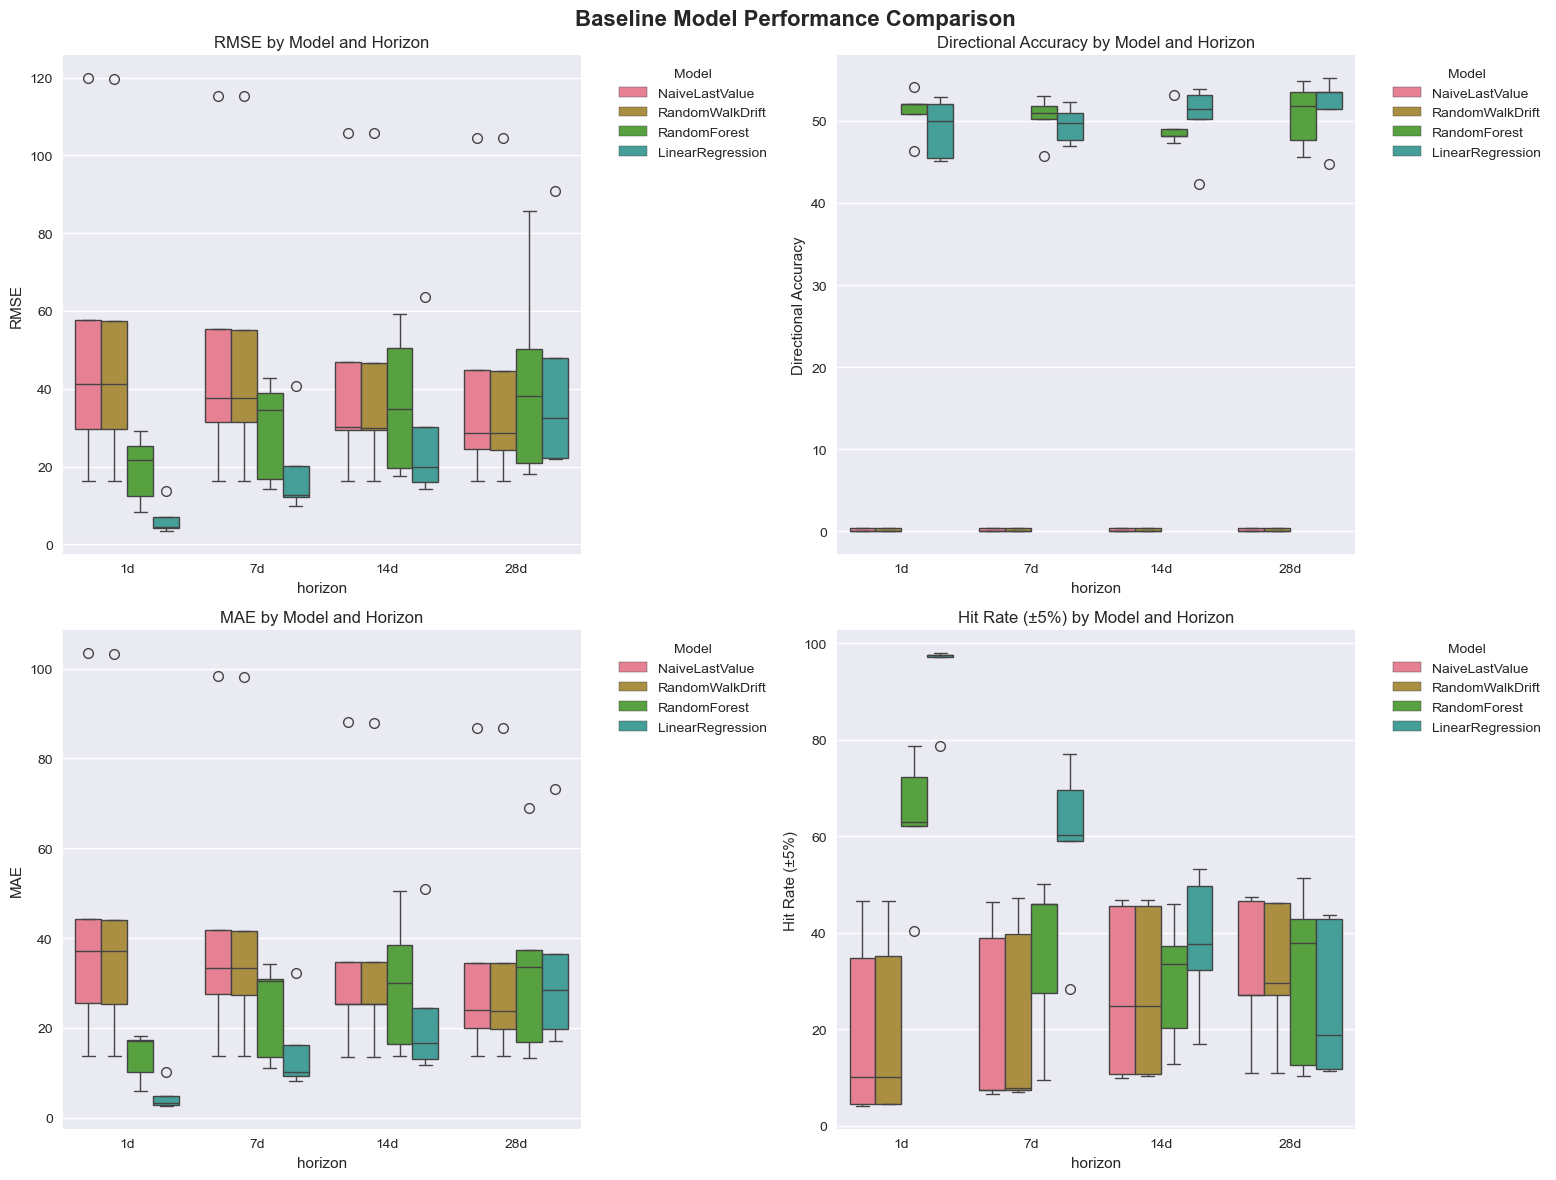

In [47]:
print("\n📈 STEP 6: Visualization of Results")
print("-" * 50)

if combined_results:
    print("🎨 Creating comprehensive visualizations...")
    ensure_dir_exists('../experiments/figures/')
    
    # Create comprehensive 4-subplot visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Baseline Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # RMSE by Model and Horizon
    sns.boxplot(data=final_results, x='horizon', y='rmse', hue='model', ax=axes[0,0])
    axes[0,0].set_title('RMSE by Model and Horizon', fontsize=12)
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Directional Accuracy by Model and Horizon
    sns.boxplot(data=final_results, x='horizon', y='directional_accuracy', hue='model', ax=axes[0,1])
    axes[0,1].set_title('Directional Accuracy by Model and Horizon', fontsize=12)
    axes[0,1].set_ylabel('Directional Accuracy')
    axes[0,1].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # MAE by Model and Horizon
    sns.boxplot(data=final_results, x='horizon', y='mae', hue='model', ax=axes[1,0])
    axes[1,0].set_title('MAE by Model and Horizon', fontsize=12)
    axes[1,0].set_ylabel('MAE')
    axes[1,0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Hit Rate (±5%) by Model and Horizon
    sns.boxplot(data=final_results, x='horizon', y='hit_rate_5pct', hue='model', ax=axes[1,1])
    axes[1,1].set_title('Hit Rate (±5%) by Model and Horizon', fontsize=12)
    axes[1,1].set_ylabel('Hit Rate (±5%)')
    axes[1,1].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Make room for legends
    plt.savefig('../experiments/figures/baseline_model_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Comprehensive model comparison plot saved")
    plt.show()
    
else:
    print("⚠️ No results available for visualization")

## 💾 7: Save Results and Generate Summary Report

In [51]:
print("\n💾 STEP 7: Save Results and Generate Summary Report")
print("-" * 50)

if combined_results:
    # Save all results using existing utility functions
    ensure_dir_exists(get_project_path('experiments/results'))
    
    # Save detailed results
    final_results.to_csv(get_project_path('experiments/results/baseline_model_results.csv'), index=False)
    print("✅ Detailed results saved to experiments/results/baseline_model_results.csv")
    
    if not sig_results_df.empty:
        sig_results_df.to_csv('experiments/results/baseline_statistical_significance.csv', index=False)
        print("✅ Statistical significance results saved")
    
    # Prepare JSON-safe results with proper column handling
    results_dict = {
        'detailed_results': final_results.to_dict('records'),
        'statistical_significance': sig_results_df.to_dict('records') if not sig_results_df.empty else []
    }

    # Safely convert summary DataFrames by flattening multi-level columns
    if 'model_summary' in locals():
        # Flatten multi-level columns first
        model_summary_flat = model_summary.copy()
        model_summary_flat.columns = ['_'.join(col).strip() for col in model_summary.columns]
        results_dict['model_summary'] = model_summary_flat.reset_index().to_dict('records')

    if 'horizon_summary' in locals():
        # Flatten multi-level columns first  
        horizon_summary_flat = horizon_summary.copy()
        horizon_summary_flat.columns = ['_'.join(col).strip() for col in horizon_summary.columns]
        results_dict['horizon_summary'] = horizon_summary_flat.reset_index().to_dict('records')

    save_results_to_json(results_dict, get_project_path('experiments/results/baseline_results_complete.json'))
    print("✅ Complete results saved as JSON")
    
    print("💾 Results saved to experiments/results/")
    
else:
    print("⚠️ No results to save")


# Generate comprehensive report using existing function
if combined_results:
    try:
        summary_report = generate_performance_report(final_results)
        
        with open(get_project_path('experiments/results/baseline_summary_report.md'), 'w') as f:
            f.write(summary_report)
        
        print("📋 Summary report generated: experiments/results/baseline_summary_report.md")
    
    except Exception as e:
        print(f"⚠️ Using fallback report generation: {str(e)}")
        
        # Fallback report generation
        report = []
        report.append("# BASELINE MODELS SUMMARY REPORT")
        report.append("=" * 50)
        report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append("")
        
        # Overview
        report.append("## OVERVIEW")
        report.append(f"- Models Evaluated: {final_results['model'].nunique()}")
        report.append(f"- Prediction Horizons: {', '.join(final_results['horizon'].unique())}")
        report.append(f"- Stocks Analyzed: {', '.join(final_results['ticker'].unique())}")
        report.append(f"- Total Experiments: {len(final_results)}")
        report.append("")
        
        # Best performing models
        report.append("## BEST PERFORMING MODELS")
        report.append("")
        
        for metric in ['rmse', 'mae', 'directional_accuracy']:
            ascending = metric not in ['directional_accuracy', 'hit_rate_5pct']
            best = final_results.groupby(['model'])[metric].mean().sort_values(ascending=ascending)
            
            report.append(f"### {metric.upper()}:")
            for i, (model, value) in enumerate(best.items()):
                rank = f"{i+1}."
                report.append(f"{rank} {model}: {value:.4f}")
            report.append("")
        
        summary_report = "\n".join(report)
        
        with open('experiments/results/baseline_summary_report.md', 'w') as f:
            f.write(summary_report)
        
        print("📋 Fallback summary report generated")



💾 STEP 7: Save Results and Generate Summary Report
--------------------------------------------------
✅ Detailed results saved to experiments/results/baseline_model_results.csv
2025-09-26 09:33:11 - root - INFO - Results saved to /Users/hossameldinsalama/Downloads/Data-science/Data science course/Udacity/Data scientist/Data Scientist Capstone/capstone-stock-predictor Project/capstone_stock_predictor/experiments/results/baseline_results_complete.json
✅ Complete results saved as JSON
💾 Results saved to experiments/results/
📋 Summary report generated: experiments/results/baseline_summary_report.md


## 🎉 Final Summary and Next Steps

In [ ]:
if combined_results:
    # Display final summary
    print("\n" + "="*60)
    print("🎉 BASELINE MODEL EVALUATION COMPLETE!")
    print("="*60)
    
    print(f"\n📊 Performance Summary:")
    print(f"   Models Trained: {final_results['model'].nunique()}")
    print(f"   Total Experiments: {len(final_results)}")
    
    print(f"\n🏆 Best Overall Performers:")
    best_rmse = final_results.groupby('model')['rmse'].mean().idxmin()
    best_direction = final_results.groupby('model')['directional_accuracy'].mean().idxmax()
    print(f"   Lowest RMSE: {best_rmse}")
    print(f"   Best Direction: {best_direction}")
    
    print(f"\n📁 Files Saved:")
    print(f"   📊 Results: experiments/results/")
    print(f"   🤖 Models: experiments/models/")
    print(f"   📈 Plots: experiments/figures/")
    
    print("\n🚀 Ready to proceed with advanced models (LightGBM, XGBoost)!")
    print("   Next: 05_advanced_models_lightgbm.ipynb")
    
else:
    print("\n❌ BASELINE MODEL EVALUATION INCOMPLETE")
    print("⚠️ No results to analyze - check model training step")
    print("🔧 Debug: Check data loading and feature preparation")

# %% [markdown]
# ## 📋 Experiment Summary
# 
# ### 🎯 Objectives Achieved:
# - ✅ Implemented 4 baseline models (Naive, Random Walk, Random Forest, Linear Regression)
# - ✅ Used existing functions from src modules (no recreation)
# - ✅ Evaluated with walk-forward validation
# - ✅ Saved all artifacts to experiments/ structure
# - ✅ Generated comprehensive performance comparisons
# - ✅ Created statistical significance tests
# - ✅ Generated visualizations and reports
# 
# ### 📊 Key Performance Metrics:
# - **RMSE**: Root Mean Square Error
# - **MAE**: Mean Absolute Error  
# - **MAPE**: Mean Absolute Percentage Error
# - **Directional Accuracy**: Percentage of correct price direction predictions
# - **Hit Rate**: Percentage of predictions within ±5% tolerance
# 
# ### 📁 Saved Artifacts:
# - **Models**: `experiments/models/*.pkl`
# - **Results**: `experiments/results/*.csv`, `*.json`, `*.md`
# - **Figures**: `experiments/figures/*.png`
# 
# ### 🔄 Next Steps:
# 1. **Advanced Models**: Implement LightGBM and XGBoost in `05_advanced_models_lightgbm.ipynb`
# 2. **Deep Learning**: Develop LSTM models in `06_deeplearning_lstm.ipynb`
# 3. **Final Evaluation**: Compare all models in `07_evaluation_and_backtest.ipynb`